In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
# os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME_HERE'
# os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY_HERE'

# !pip install kaggle
# !kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip

# ROOT = '../test_data/superHands/piece'
train_dir="../test_data/ML_test_DataSet/Face_Mask_Dataset/Train/"
test_dir="../test_data/ML_test_DataSet/Face_Mask_Dataset/Test/"
valid_dir="../test_data/ML_test_DataSet/Face_Mask_Dataset/Validation/"

# datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)


In [4]:
# TRAIN_RATIO = 0.8

# data_dir = os.path.join(ROOT, '')
# images_dir = os.path.join(data_dir, 'images')
# train_dir = os.path.join(data_dir, 'train')
# test_dir = os.path.join(data_dir, 'test')
# print(test_dir)
# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir) 
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
    
# os.makedirs(train_dir)
# os.makedirs(test_dir)

classes = os.listdir(train_dir)
classes.sort()

print(classes)
# for c in classes:
    
#     class_dir = os.path.join(images_dir, c)
    
#     images = os.listdir(class_dir)
       
#     n_train = int(len(images) * TRAIN_RATIO)
    
#     train_images = images[:n_train]
#     test_images = images[n_train:]
    
#     os.makedirs(os.path.join(train_dir, c), exist_ok = True)
#     os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
#     for image in train_images:
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(train_dir, c, image) 
#         shutil.copyfile(image_src, image_dst)
        
#     for image in test_images:
#         image_src = os.path.join(class_dir, image)
#         image_dst = os.path.join(test_dir, c, image) 
#         shutil.copyfile(image_src, image_dst)

['WithMask', 'WithoutMask']


Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the mean and std is slightly different than when using a dataset provided by torchvision as those datasets have all of the images stored as numpy arrays in the data's `data` attribute, whilst datasets loaded by `ImageFolder` and `DataFolder` do not.

First, we load the `train_data` from the `train` folder. Remember: the mean and std must only be calculated from the training data. This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.

Again, this only needs to be calculated once per dataset and the means and stds calculated here can be re-used without calculating them for other runs. The exception to this is if we used a different train/test split, then we would need to calculate these again.

In [16]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

TypeError: __init__() got an unexpected keyword argument 'shuffle'

Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the same data augmentation as always: randomly rotating, flipping horizontally and cropping.

In [6]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

valid_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [8]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

valid_data = datasets.ImageFolder(root = valid_dir, 
                                 transform = valid_transforms)                        

print(train_dir)

../test_data/ML_test_DataSet/Face_Mask_Dataset/Train/


...create the validation split...

In [9]:
# VALID_RATIO = 0.9

# n_train_examples = int(len(train_data) * VALID_RATIO)
# n_valid_examples = len(train_data) - n_train_examples

# train_data, valid_data = data.random_split(train_data, 
#                                            [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [10]:
# valid_data = copy.deepcopy(valid_data)
# valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 10000
Number of validation examples: 800
Number of testing examples: 992


Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [12]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [14]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

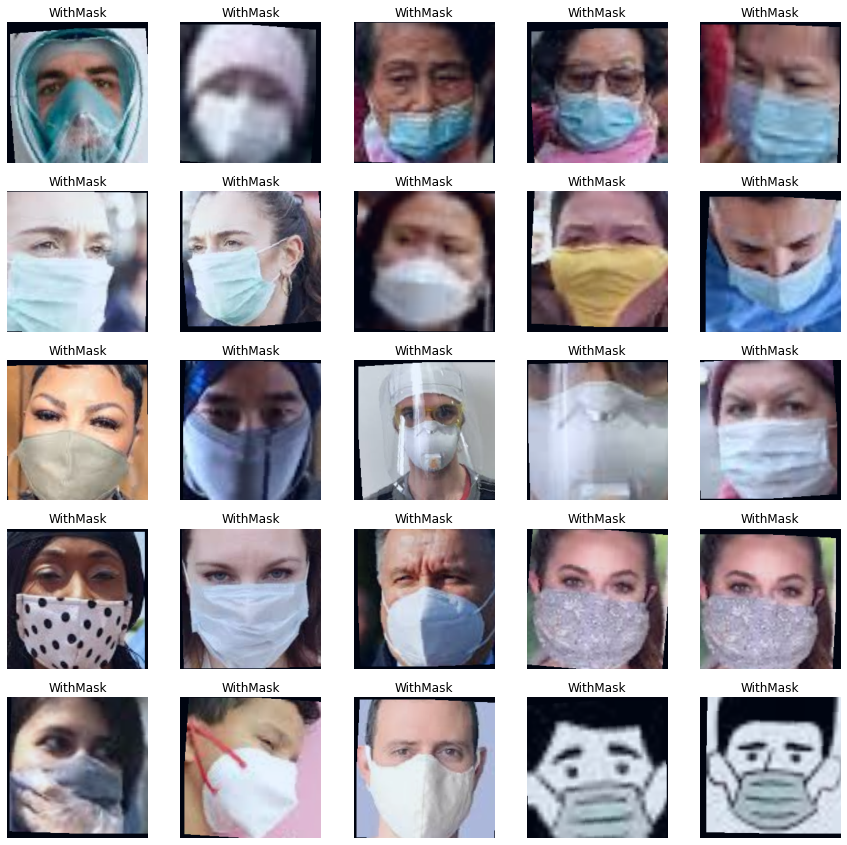

In [15]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the `train` and `test` folders. 

Another approach is to directly change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [15]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

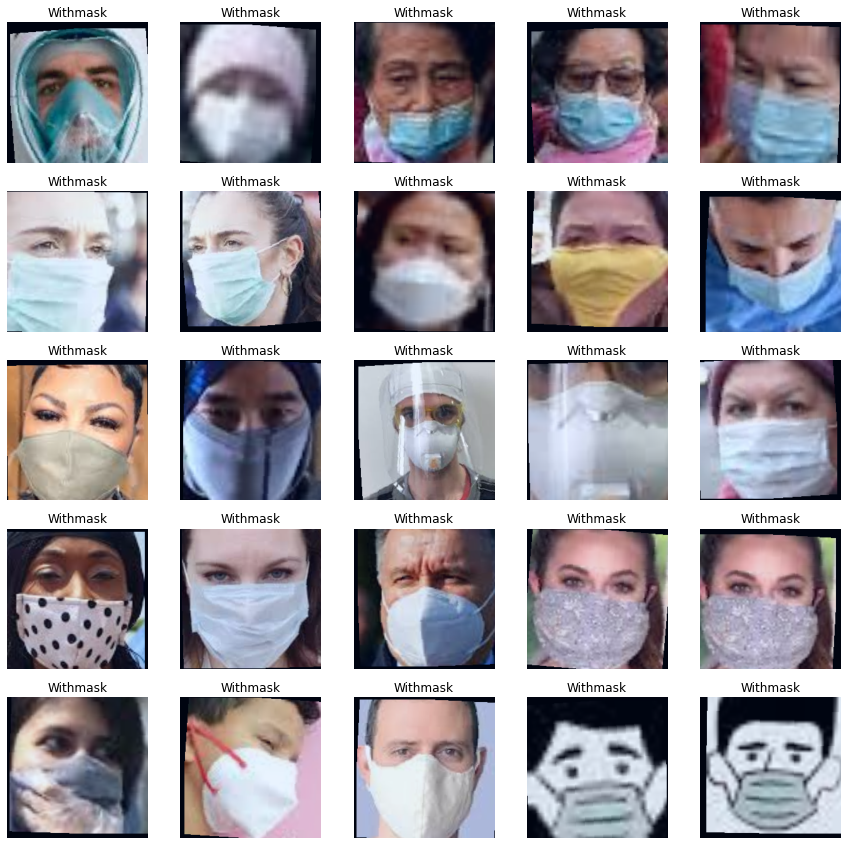

In [16]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

### Defining the Model

Next up, we'll be defining our model. As mentioned previously, we'll be using one of the residual network (ResNet) models. Let's look at the ResNet configuration table again:

![](assets/resnet-table.png)

As we can see, there is a common 7x7 convolutional layer and max pooling layer at the start of all ResNet models - these layers also have padding, which is not shown in the table. These are followed by four "layers", each containing a different number of blocks. There are two different blocks used, one for the ResNet18 and ResNet34 - called the `BasicBlock` - , and one for the ResNet50, ResNet101 and ResNet152 - called the `Bottleneck` block.

Our `ResNet` class defines the initial 7x7 convolutional layer along with batch normalization, a ReLU activation function and a downsampling max pooling layer. We then build the four layers from the provided configuration, `config`, which specifies: the block to use, the number of blocks in the layer, and the number of channels in that layer. For the `BasicBlock` the number of channels in a layer is simply the number of filters for both of the convolutional layers within the block. For the `Bottleneck` block, the number of channels refers to the number of filters used by the first two convolutional layers - the number of the filters in the final layer is the number of channels multiplied by an `expansion` factor, which is 4 for the `Bottleneck` block (and 1 for the `BasicBlock`). Also note that the `stride` of the first layer is one, whilst the `stride` of the last three layers is two. This `stride` is only used to change the `stride` of the first convolutional layer within a block and also in the "downsampling" residual path - we'll explain what downsampling in ResNets means shortly.

`get_resnet_layer` is used to define the layers from the configuration by creating a `nn.Sequential` from a list of blocks. The first thing it checks is if the first block in a layer needs to have a downsampling residual path - only the first block within a layer ever needs to have a downsampling residual path. So, what is a downsampling residual path?

![](assets/resnet-skip.png)

Remember that the key concept in the ResNet models is the residual (aka skip/identity) connection. However, if the number of channels within the image is changed in the main connection of the block then it won't have the same number of channels as the image from the residual connection and thus we cannot sum them together. Consider the first block in second layer of ResNet18, the image tensor passed to it will have 64 channels and the output will have 128 channels. Thus, we need to make a residual connection between a 64 channel tensor and a 128 channel tensor. ResNet models solve this using a downsampling connection - technically, it doesn't always downsample the image as sometimes the image height and width stay the same - which increases the number of channels in the image through the residual connection by passing them through a convolutional layer. 

Thus, to check if we need to downsample within a block or not, we simply check if the number of channels into the block - `in_channels` - is the number of channels out of the block - defined by the `channels` argument multipled by the `expansion` factor of the block. Only the first block in each layer is checked if it needs to downsample or not. After each layer is created, we update `in_channels` to be the number of channels of the image when it is output by the layer.

We then follow the four layers with a 1x1 adaptive average pool. This will take the average over the entire height and width of the image separately for each channel. Thus, if the input to the average pool is `[512, 7, 7]` (512 channels and a height and width of seven) then the output of the average pool will be `[512, 1, 1]`. We then pass this average pooled output to a linear layer to make a prediction. We always know how many channels will be in the image after the fourth layer as we continuously update `in_channels` to be equal to the number of the channels in the image output by each layer.

One thing to note is that the initial convolutional layer has `bias = False`, which means there is no bias term used by the filters. In fact, every convolutional layer used within every ResNet model always has `bias = False`. The authors of the ResNet paper argue that the bias terms are unnecessary as every convolutional layer in a ResNet is followed by a batch normalization layer which has a $\beta$ (beta) term that does the same thing as the bias term in the convolutional layer, a simple addition. See the previous notebook for more details on how batch normalization works.

In [17]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        self.dropout = nn.Dropout(p=0.5)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.dropout(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h


First up is the `BasicBlock`. 

The `BasicBlock` is made of two 3x3 convolutional layers. The first, `conv1`, has `stride` which varies depending on the layer (one in the first layer and two in the other layers), whilst the second, `conv2`, always has a `stride` of one. Each of the layers has a `padding` of one - this means before the filters are applied to the input image we add a single pixel, that is zero in every channel, around the entire image. Each convolutional layer is followed by a ReLU activation function and batch normalization. 

As mentioned in the previous notebook, it makes more sense to use batch normalization after the activation function, rather than before. However, the original ResNet models used batch normalization before the activation, so we do here as well.

When downsampling, we add a convolutional layer with a 1x1 filter, and no padding, to the residual path. This also has a variable `stride` and is followed by batch normalization. With a stride of one, a 1x1 filter does not change the height and width of an image - it simply has `out_channels` number of filters, each with a depth of `in_channels`, i.e. it is increasing the number of channels in an image via a linear projection and not actually downsampling at all. With a stride of two, it reduces the height and width of the image by two as the 1x1 filter only passes over every other pixel - this time it is actually downsampling the image as well as doing the linear projection of the channels.

The `BasicBlock` has an `expansion` of one as the number of filters used by each of the convolutional layers within a block is the same.

In [18]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

Before we detail the `Bottleneck` block, we'll first show how to create the configurations for the ResNet models.

Instead of using a simple list, like we did the for the VGG model in the previous notebook, we'll use a `namedtuple`. This will store: the block class, the number of blocks in each layer, and the number of channels in each layer.

In [19]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

From the ResNet configuration table, we can create the following configurations for ResNet18 and ResNet34. Notice how the specified `channels` does not change across configurations, simply the number of blocks used in each layer.

We could then define the ResNet18 and ResNet34 models with:

```python
resnet18 = ResNet(resnet18_config, output_dim)
resnet34 = ResNet(resnet34_config, output_dim)
```

In [20]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

The `Bottleneck` block, used for ResNet50, ResNet101 and ResNet152. 

Instead of two 3x3 convolutional layers it has a 1x1, 3x3 and then another 1x1 convolutional layer. Only the 3x3 convolutional layer has a variable stride and padding, whilst the 1x1 filters have a stride of one and no padding.

The first 1x1 filter, `conv1`, is used to reduce the number of channels in all layers except the first, where it keeps the number of channels the same, e.g. in first block in of second layer it goes from 256 channels to 128. In the case where a 1x1 filter reduces the number of channels it can be thought of as a pooling layer across the channel dimension, but instead of doing a simple maximum or average operation it learns - via its weights - how to most efficiently reduce dimensionality. Reducing the dimensionality is also useful for simply reducing the number of parameters within the model and making it feasible to train.

The second 1x1 filter, `conv3`, is used to increase the number of channels - similar to the convolutional layer in the downsampling path.

The `Bottleneck` block has an `expansion` of four, which means that the number of channels in the image output a block isn't `out_channels`, but `expansion * out_channels`. 

The downsampling convolutional layer is similar to that used in the `BasicBlock`, with the `expansion` factor taken into account.

In [21]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

Below are the configurations for the ResNet50, ResNet101 and ResNet152 models. 

Similar to the ResNet18 and ResNet34 models, the `channels` do not change between configurations, just the number of blocks in each layer.

We can use the configurations to get the actual models as:

```python
resnet50 = ResNet(resnet50_config, output_dim)
resnet101 = ResNet(resnet101_config, output_dim)
resnet152 = ResNet(resnet152_config, output_dim)
```

In [22]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

The ResNet paper also covers variants specifically for the CIFAR10/100 datasets which we'll very briefly cover here. The code for them is adapted from [this](https://github.com/akamaster/pytorch_resnet_cifar10) repository.

The initial convolutional layer has smaller filter size, lower stride and less padding, and is not followed by a pooling layer. It also only has 3 layers, instead of 4, and has its own type of block.

One requirement is that the number of channels for each layer has to be exactly double that of the previous layer - this is checked by the second `assert` statement.

In [23]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

The `CIFARBasicBlock` is similar to the standard `BasicBlock`, the only difference is in the downsampling residual connection.

The [paper](https://arxiv.org/abs/1512.03385) states that the ResNet models for CIFAR use a downsampling connection that uses "zero padding" and "all shortcuts are parameter free". We achieve this by using an `Identity` module, which is initialized with a function and applies that function when called.

For the function, we first slice the input with `x[:, :, ::2, ::2]`. This removes every other row and column in the image - downsampling it by simply throwing away pixels - whilst keeping the number of channels (depth) the same.

![](assets/resnet-pad.png)

We then double the number of channels with zeros using `pad`, which adds half the padding on to the front of the depth dimension, and half to the back.

In [24]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

Below are the configurations for the CIFAR ResNet models. 

Similar to previous ResNet models, the `channels` do not change across configurations, just the number of blocks in each layer.

We can use the configurations to get the actual models as:

```python
ciafar_resnet_20 = CIFARResNet(cifar_resnet20_config, output_dim)
ciafar_resnet_32 = CIFARResNet(cifar_resnet32_config, output_dim)
ciafar_resnet_44 = CIFARResNet(cifar_resnet44_config, output_dim)
```

In [25]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [7, 7, 7],
                                     channels = [16, 32, 64])

cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [9, 9, 9],
                                     channels = [16, 32, 64])

cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock,
                                      n_blocks = [18, 18, 18],
                                      channels = [16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock,
                                       n_blocks = [20, 20, 20],
                                       channels = [16, 32, 64])

The images in our dataset are around 500x500 pixels in size, much larger than the 32x32 images used in the CIFAR dataset. This means it's more appropriate for us to use one of the standard ResNet models, instead of the CIFAR versions.

We'll choose ResNet50 as it seems to be the most commonly used ResNet variant. 

As we have a relatively small dataset - 12,000 images - with a very small amount of examples per class - 60 images - we'll be using a pre-trained model.

Torchvision provides pre-trained models for all of the standard ResNet variants, but unfortunately not for any of the CIFAR ResNet models.

First, we load the pre-trained ResNet model.

In [26]:
pretrained_model = models.resnet50(pretrained = True)

We can see that the final linear layer for the classification, `fc`, has a 1000-dimensional output as it was pre-trained on the ImageNet dataset, which has 1000 classes. 

In [27]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Our dataset, however, only has 200 classes, so we first create a new linear layer with the required dimensions.

In [28]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

**Note:** even if our dataset had 1000 classes, the same as ImageNet, we would still remove the linear layer and replace it with a randomly initialized one as our classes are not equal to those of ImageNet. 

In [29]:
pretrained_model.fc = fc

The pre-trained ResNet model provided by torchvision does not provide an intermediate output, which we'd like to potentially use for analysis. We solve this by initializing our own ResNet50 model and then copying the pre-trained parameters into our model.

We then initialize our ResNet50 model from the configuration...

In [30]:
model = ResNet(resnet50_config, OUTPUT_DIM)

...then we load the parameters (called `state_dict` in PyTorch) of the pre-trained model into our model.

This is also a good sanity check to ensure our ResNet model matches those used by torchvision.

In [31]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

We can also see the number of parameters in our model - noticing that ResNet50 only has ~24M parameters compared to VGG11's ~129M. This is mostly due to the lack of high dimensional linear layers which have been replaced by more parameter efficient convolutional layers.

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


### Training the Model

Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [33]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We define the learning rate finder class.

See notebook 3 for a reminder on how this works.

In [34]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

We then define our learning rate finder and run the range test.

In [35]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [36]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

We can see that the loss reaches a minimum at around $3x10^{-3}$.

A good learning rate to choose here would be the middle of the steepest downward curve - which is around $1x10^{-3}$.

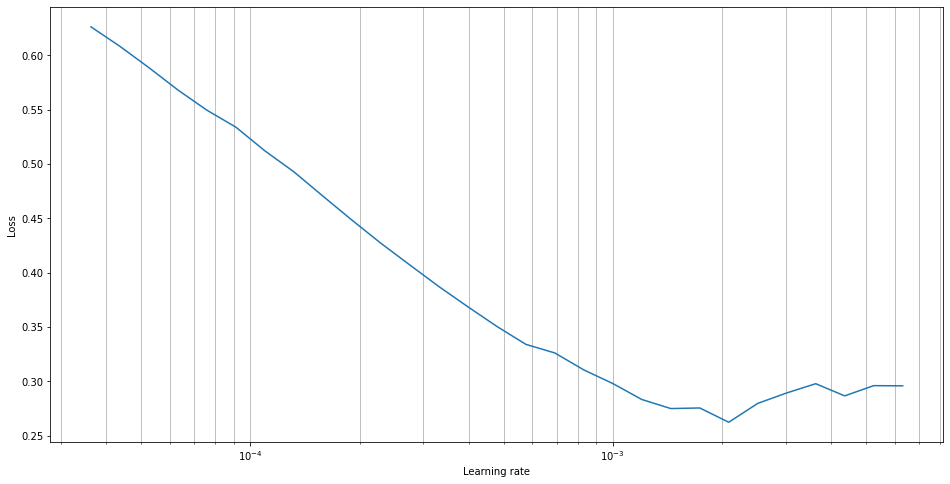

In [37]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

We can then set the learning rates of our model using discriminative fine-tuning - a technique used in transfer learning where later layers in a model have higher learning rates than earlier ones.

We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input. 

In [38]:
FOUND_LR = 2e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

Next up, we set the learning rate scheduler. A learning rate scheduler dynamically alters the learning rate whilst the model is training. We'll be using the one cycle learning rate scheduler, however [many](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) schedulers are available in PyTorch.

The one cycle learning rate scheduler starts with a small initial learning rate which is gradually increased to a maximum value - the value found by our learning rate finder - it then slowly decreases the learning rate to a final value smaller than the initial learning rate. This learning rate is updated after every parameter update step, i.e. after every training batch. For our model, the learning rate for the final `fc` layer throughout training will look like:

![](assets/lr-scheduler.png)

As we can see, it starts at slightly less than $1x10^{-4}$ before gradually increasing to the maximum value of $1x10^{-3}$ at around a third of the way through training, then it begins decreasing to almost zero.

The different parameter groups defined by the optimizer for the discriminative fine-tuning will all have their own learning rate curves, each with different starting and maximum values.

The hypothesis is that the initial stage where the learning rate increases is a "warm-up" phase is used to get the model into a generally good area of the loss landscape. The middle of the curve, where the learning rate is at maximum is supposedly good for acting as a regularization method and prevents the model from overfitting or becoming stuck in saddle points. Finally, the "cool-down" phase, where the learning rate decreases, is used to reach small crevices in the loss surface which have a lower loss value.

The one cycle learning rate also cycles the momentum of the optimizer. The momentum is cycled from a maximum value, down to a minimum and then back up to the maximum where it is held constant for the last few steps. The default maximum and minimum values of momentum used by PyTorch's one cycle learning rate scheduler should be sufficient and we will not change them.

To set-up the one cycle learning rate scheduler we need the total number of steps that will occur during training. We simply get this by multiplying the number of epochs with the number of batches in the training iterator, i.e. number of parameter updates. We get the maximum learning rate for each parameter group and pass this to `max_lr`. **Note:** if you only pass a single learning rate and not a list of learning rates then the scheduler will assume this learning rate should be used for all parameters and will **not** do discriminative fine-tuning.

In [40]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]
print(MAX_LRS)
scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

[8.000000000000005e-06, 8.000000000000005e-06, 9.999999999999999e-06, 1.333333333333335e-05, 1.9999999999999998e-05, 3.9999999999999996e-05, 7.999999999999999e-05]


One other thing we are going to implement is top-k accuracy. Our task is to classify an image into one of 200 classes of bird, however some of these classes look very similar and it is even difficult for a human to correctly label them. So, maybe we should be more lenient when calculating accuracy? 

One method of solving this is using top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our `calculate_topk_accuracy` function calculates the top-1 accuracy as well as the top-k accuracy, with $k=5$ by default.

We use `.reshape` instead of view here as the slices into tensors cause them to become non-contiguous which means `.view` throws an error. As a rule of thumb, if you are aiming to change the size/shape of sliced tensors then you should probably use `.reshape` instead of `.view`.

**Note:** our value of k should be chosen sensibly. If we had a dataset with 10 classes then a k of 5 isn't really that informative.

In [43]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Next up is the training function. This is similar to all the previous notebooks, but with the addition of the `scheduler` and calculating/returning top-k accuracy.

The scheduler is updated by calling `scheduler.step()`. This should always be called **after** `optimizer.step()` or else the first learning rate of the scheduler will be skipped. 

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the `train` function and can be called in the main training loop.

In [44]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_k = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_k = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_k += acc_k.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_k /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_k

The evaluation function is also similar to previous notebooks, with the addition of the top-k accuracy.

As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

In [45]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_k = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_k = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_k += acc_k.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_k /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_k

Next, a small helper function which tells us how long an epoch has taken.

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

We get around 80% top-1 and 95% top-5 validation accuracy.

In [47]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @2: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @2: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 58s
	Train Loss: 0.309 | Train Acc @1:  87.30% | Train Acc @2: 100.00%
	Valid Loss: 0.034 | Valid Acc @1: 100.00% | Valid Acc @2: 100.00%
Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 0.017 | Train Acc @1:  99.71% | Train Acc @2: 100.00%
	Valid Loss: 0.003 | Valid Acc @1: 100.00% | Valid Acc @2: 100.00%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 0.008 | Train Acc @1:  99.80% | Train Acc @2: 100.00%
	Valid Loss: 0.001 | Valid Acc @1: 100.00% | Valid Acc @2: 100.00%


KeyboardInterrupt: 

The test accuracies are a little lower than the validation accuracies, but not by so much that we should be concerned.

In [ ]:
model.load_state_dict(torch.load('tut5-model_all_5.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

### Examining the Model

We'll be doing the same examinations of the model as done in previous notebooks.

First, we get the predictions for each image in the test set...

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)


In [ ]:
demo_dir='piece/all/demo/'
demo_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
demo_data = datasets.ImageFolder(root = demo_dir, 
                                 transform = demo_transforms)
demo_iterator = data.DataLoader(demo_data,
                                batch_size = BATCH_SIZE)
images, labels, probs = get_predictions(model, demo_iterator)
pred_labels = torch.argmax(probs, 1)
print(pred_labels, labels)
corrects = torch.eq(labels, pred_labels)
print(corrects)

... which we then use to get the predicted labels.

In [ ]:
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
print(corrects)

We then use this to plot a confusion matrix.

A 200x200 confusion matrix is pretty large, so we've increased the figure size and removed the colorbar. The text is still too small to read, but all we care about is that the diagonals are generally darker than the rest of the matrix - which they are.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes)
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
import seaborn as sns

def plot_confusion_matrix_nomalized(labels, pred_labels, classes):
    # fig = plt.figure(figsize = (20, 20))
    # ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
    plt.show(block=False)

def plot_confusion_matrix_nomalized_reversed(labels, pred_labels, classes):
    # fig = plt.figure(figsize = (20, 20))
    # ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(pred_labels, labels)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.xlabel('True Label', fontsize = 50)
    plt.ylabel('Predicted Label', fontsize = 50)
    plt.show(block=False)


In [ ]:
print(labels, pred_labels, classes)
plot_confusion_matrix(labels,pred_labels, classes)
plot_confusion_matrix_nomalized(labels,pred_labels, classes)
plot_confusion_matrix_nomalized_reversed(labels, pred_labels, classes)

We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class. 

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

From the names of the classes (and a bit of image searching) we can see that the incorrect predictions are usually sensible, e.g. magnolia warbler and cape may warbler, marsh wren and carolina wren.

The most incorrectly predicted image might also be a mislabeled example as worm eating warblers do not have a black and white underside.

In [ ]:
N_IMAGES = 10

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

We can also get the representations from the model in order to perform some dimensionality reduction techniques.

In this notebook we'll only get the output representations, and not the intermediate ones.

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_iterator)

We can then perform PCA on these representations to plot them in two dimensions.

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

As there are 200 classes, it is difficult for every class to have a unique color. 

Also a legend with 200 elements is quite large, so we do not plot it - however we leave the code (commented out) to do so if required.

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'viridis')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

The classes do not seem as well separated as in previous notebooks, although this is most probably due to there being so many classes.

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

Next up, we plot the t-SNE data. As we have a much smaller dataset than the CIFAR datasets used previously we can perform t-SNE on the entire dataset in a reasonable amount of time.

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

The classes are definitely well separated here - which is usually a good sign.

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

We can then plot what a few of the images look like after having gone through the first convolutional layer.

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters perform many different types of image processing - from edge detection to color inversion.

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the values of the filters themselves.

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

There are some interesting patterns contained in these filters, however all of these were already present in the pre-trained ResNet model. The learning rate used on this initial convolutional layer was most probably too small to change these significantly.

In [ ]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- downloading and extracting custom datasets
- loading custom datasets
- calculating the mean and std for normalization on custom datasets
- loading transforms to augment and normalize our data
- defining a ResNet model
- defining the ResNet blocks
- defining a CIFAR ResNet model
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to use the learning rate finder
- how to use discriminative fine-tuning
- how to use the one cycle learning rate scheduler
- fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model